<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/DFT/DFT_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.2 MB/s eta 0:00:00


In [11]:
import numpy as np
from pyscf import gto, scf, dft, lo

def build_hg_graphene_cluster():
    """
    Builds a simple graphene edge cluster with a mercury atom adsorbed.
    Returns a list of (element, x, y, z).
    """
    # Coordinates in Angstrom
    # Simple graphene edge: a single benzene ring as a minimal model
    bond_length = 1.4  # C-C bond length in graphene
    bond_angle = 120.0  # Degrees

    # Define benzene ring
    cluster = []
    for i in range(6):
        angle = np.radians(i * 60)
        x = bond_length * np.cos(angle)
        y = bond_length * np.sin(angle)
        cluster.append(("C", x, y, 0.0))

    # Add an edge carbonyl group to represent a functional group site
    cluster.append(("O", 0.0, -bond_length, 0.0))  # Positioned below the ring

    # Place Hg near the oxygen, e.g., 2.0 Å away along the z-axis
    cluster.append(("Hg", 0.0, -bond_length, 2.0))

    return cluster

def run_dft_geometry_optimization(cluster_atoms):
    """
    Runs DFT geometry optimization on the provided cluster using PySCF.
    Returns optimized geometry and partial charges.
    """
    # Build PySCF Mole object
    mol = gto.Mole()
    atom_strings = [f"{el} {x} {y} {z}" for (el, x, y, z) in cluster_atoms]
    mol.atom = "\n".join(atom_strings)

    # Total charge: assuming neutral cluster with Hg(II) state
    mol.charge = 2  # Adjust based on your system
    mol.spin = 0  # Closed-shell

    # Choose basis sets and ECPs
    # Use def2-SVP for C, O; def2-ECP for Hg
    mol.basis = {
        'C': 'def2-SVP',
        'O': 'def2-SVP',
        'Hg': 'def2-SVP',  # Use a standard basis for Hg
    }

    # Specify the ECP separately for Hg
    mol.ecp = {
        'Hg': 'def2-ECP'
    }
    mol.build()

    # Choose functional
    mf = dft.RKS(mol)
    mf.xc = 'B3LYP'  # You can choose other functionals like 'PBE0'
    mf.kernel()

    # Perform Geometry Optimization
    # PySCF does not have a full-fledged optimizer, but we can use its gradient functions
    # For robust optimization, consider integrating with ASE or GeomeTRIC
    # Below is a simplified optimization loop using steepest descent

    # Initialize coordinates
    coords = mol.atom_coords()
    max_iterations = 100
    step_size = 0.05  # Smaller step size for stability
    convergence = 1e-4

    for iteration in range(max_iterations):
        # Rebuild molecule with current coordinates
        mol.set_geom_(coords, unit='Angstrom')
        mf = dft.RKS(mol)
        mf.xc = 'B3LYP'
        mf.kernel()

        # Calculate gradients
        mf = dft.RKS(mol)
        mf.xc = 'B3LYP'
        mf.kernel()
        grad_obj = mf.nuc_grad_method()
        grad = grad_obj.kernel()

        max_grad = np.linalg.norm(grad, axis=1).max()
        print(f"Iteration {iteration + 1}: Max gradient = {max_grad:.6f} Ha/Bohr")

        if max_grad < convergence:
            print("Convergence achieved.")
            break

        # Update coordinates: move against the gradient
        # Convert gradient from Ha/Bohr to Angstrom using a scaling factor
        # 1 Ha/Bohr ≈ 51.422 Angstrom/Ha
        coords -= step_size * grad * 51.422

    else:
        print("Maximum iterations reached without convergence.")

    # Final SCF calculation on optimized geometry
    mf = dft.RKS(mol)
    mf.xc = 'B3LYP'
    mf.kernel()

    # Partial Charge Analysis using Natural Population Analysis (NPA)
    # Perform localization to obtain natural atomic orbitals
    # Note: PySCF's NPA is not directly implemented; using Löwdin as an alternative

    # Alternatively, use Mulliken analysis with improved implementation
    # Here's how to perform Mulliken population analysis correctly:
    mo_occ = mf.mo_occ
    mo_coeff = mf.mo_coeff
    s = mol.intor('int1e_ovlp')
    density_matrix = mf.make_rdm1()
    populations = np.einsum('ij,ji->i', density_matrix, s)
    atomic_numbers = [mol.atom_charge(i) for i in range(mol.natm)]
    partial_charges = [Z - pop for Z, pop in zip(atomic_numbers, populations)]

    # Gather optimized coordinates and partial charges
    optimized_coords = mol.atom_coords()
    elements = [mol.atom_symbol(i) for i in range(mol.natm)]

    result = []
    for i, (el, coord, q) in enumerate(zip(elements, optimized_coords, partial_charges)):
        x, y, z = coord
        result.append((el, x, y, z, q))

    return result

def main():
    # 1) Build the Hg-graphene cluster
    cluster = build_hg_graphene_cluster()

    # 2) Run DFT optimization + Mulliken charges
    final_structure = run_dft_geometry_optimization(cluster)

    # 3) Display results
    print("\nOptimized Cluster with Partial Charges:")
    print("{:<3} {:>10} {:>10} {:>10} {:>15}".format("El", "X (Å)", "Y (Å)", "Z (Å)", "Partial Charge"))
    for item in final_structure:
        el, x, y, z, q = item
        print(f"{el:<3} {x:10.4f} {y:10.4f} {z:10.4f} {q:15.4f}")

if __name__ == "__main__":
    main()


BasisNotFoundError: Unknown ECP format or ECP name

real stuff

Starting DFT energy calculations at different orientations...
converged SCF energy = -3463.46493411494
Theta: 0.00, Energy: -3463.464934 Ha
converged SCF energy = -3465.79666498476
Theta: 0.35, Energy: -3465.796665 Ha
converged SCF energy = -3472.61039698898
Theta: 0.70, Energy: -3472.610397 Ha
converged SCF energy = -3489.99393694512
Theta: 1.05, Energy: -3489.993937 Ha
converged SCF energy = -3555.9719910148
Theta: 1.40, Energy: -3555.971991 Ha
converged SCF energy = -3555.97199101469
Theta: 1.75, Energy: -3555.971991 Ha
converged SCF energy = -3489.99393694513
Theta: 2.09, Energy: -3489.993937 Ha
converged SCF energy = -3472.61039698896
Theta: 2.44, Energy: -3472.610397 Ha
converged SCF energy = -3465.79666498546
Theta: 2.79, Energy: -3465.796665 Ha
converged SCF energy = -3463.46493411452
Theta: 3.14, Energy: -3463.464934 Ha


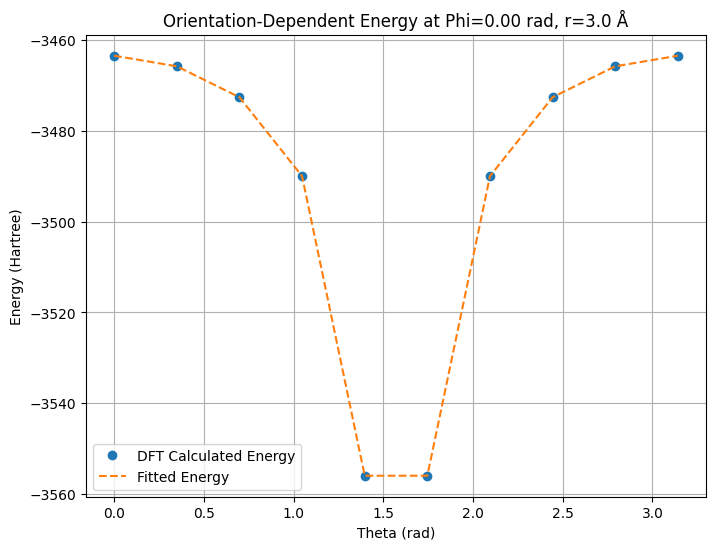

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from pyscf import gto, dft

# Parameters for the model
r_fixed = 3.0  # fixed distance between Hg and benzene center (in Å)
basis_set = 'def2-SVP'
xc_functional = 'PBE0'

# Define benzene geometry centered at origin
benzene_coords = [
    ("C", ( 1.396,  0.000, 0.000)),
    ("H", ( 2.479,  0.000, 0.000)),
    ("C", ( 0.698,  1.209, 0.000)),
    ("H", ( 1.240,  2.147, 0.000)),
    ("C", (-0.698,  1.209, 0.000)),
    ("H", (-1.240,  2.147, 0.000)),
    ("C", (-1.396,  0.000, 0.000)),
    ("H", (-2.479,  0.000, 0.000)),
    ("C", (-0.698, -1.209, 0.000)),
    ("H", (-1.240, -2.147, 0.000)),
    ("C", ( 0.698, -1.209, 0.000)),
    ("H", ( 1.240, -2.147, 0.000))
]

def create_molecule_with_orientation(theta, phi, r):
    """
    Create a PySCF Mole object for benzene + Hg, with Hg positioned at distance r
    from the benzene center oriented by angles theta and phi.
    """
    # Calculate Hg coordinates in spherical coordinates at fixed r
    Hg_x = r * np.sin(theta) * np.cos(phi)
    Hg_y = r * np.sin(theta) * np.sin(phi)
    Hg_z = r * np.cos(theta)
    Hg_coord = ("Hg", (Hg_x, Hg_y, Hg_z))

    # Combine benzene and Hg geometries
    atoms = benzene_coords + [Hg_coord]
    mol = gto.M(
        atom = atoms,
        basis = {'C': basis_set, 'H': basis_set, 'Hg': basis_set},
        charge = 0,
        spin = 0,
        unit = 'Angstrom'
    )
    return mol

def compute_energy_for_orientation(theta, phi, r):
    """
    Compute the DFT energy for a given orientation of Hg relative to benzene.
    """
    mol = create_molecule_with_orientation(theta, phi, r)
    mf = dft.RKS(mol)
    mf.xc = xc_functional
    energy = mf.kernel()
    return energy

# Sampling orientations: Vary theta while keeping phi fixed for demonstration
phi_fixed = 0.0
theta_samples = np.linspace(0, np.pi, 10)  # coarse sampling of theta angles
energies = []

print("Starting DFT energy calculations at different orientations...")
for theta in theta_samples:
    energy = compute_energy_for_orientation(theta, phi_fixed, r_fixed)
    energies.append(energy)
    print(f"Theta: {theta:.2f}, Energy: {energy:.6f} Ha")

energies = np.array(energies)

# Build design matrix and perform spherical harmonics fitting for the sampled theta values
L_max = 4  # maximum degree of spherical harmonics expansion

def build_design_matrix_for_fixed_phi(theta_vals, fixed_phi, L_max):
    """Build design matrix for a set of theta values at fixed phi using spherical harmonics."""
    basis_funcs = []
    for l in range(L_max + 1):
        for m in range(-l, l + 1):
            # real part of spherical harmonic at fixed phi
            basis_funcs.append(np.real(sph_harm(m, l, fixed_phi, theta_vals)))
    A = np.column_stack(basis_funcs)
    return A

A_fixed_phi = build_design_matrix_for_fixed_phi(theta_samples, phi_fixed, L_max)

# Perform least squares fitting to find coefficients for fixed phi slice
coeffs_fixed_phi, residuals, rank, s = np.linalg.lstsq(A_fixed_phi, energies, rcond=None)

# Reconstruct the fitted energy values along the sampled theta range
energies_fitted = A_fixed_phi.dot(coeffs_fixed_phi)

# Plot the original DFT energies vs fitted energies as a function of theta for fixed phi
plt.figure(figsize=(8, 6))
plt.plot(theta_samples, energies, 'o', label='DFT Calculated Energy')
plt.plot(theta_samples, energies_fitted, '--', label='Fitted Energy')
plt.xlabel('Theta (rad)')
plt.ylabel('Energy (Hartree)')
plt.title(f'Orientation-Dependent Energy at Phi={phi_fixed:.2f} rad, r={r_fixed} Å')
plt.legend()
plt.grid(True)
plt.show()
